## Part I. Multi-layer Feedforward Neural Network for Classification

Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
import tensorflow as tf
import warnings 
warnings.filterwarnings('ignore')

print(tf.__version__)

2.1.0


**a.** Explore the labeled data. Based on your exploratory results, identify one or more features that may be important or appear interesting to you. You should support your answers with tables and/or graphs and brief explanations.

In [2]:
train_data = pd.read_csv('hw3_labeled_data.csv', index_col = 0)
train_data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
patient_0,56,80,1.010,1,0,1,1,0,0,165,...,40,11800,5.0,1,1,0,0,1,0,1
patient_1,70,70,1.010,1,0,1,0,1,1,171,...,27,9600,3.4,0,1,0,0,0,0,1
patient_2,76,70,1.015,1,0,1,1,0,0,92,...,32,9600,3.7,1,0,0,1,0,0,1
patient_3,51,60,1.025,0,0,1,1,0,0,99,...,49,8300,5.2,0,0,0,1,0,0,0
patient_4,58,70,1.025,0,0,1,1,0,0,88,...,53,9100,5.2,0,0,0,1,0,0,0


In [3]:
train_data.isnull().sum().sum() #check if there are any missing values

0

In [4]:
train_data.dtypes # look at data types for each column

age                 int64
bp                  int64
sg                float64
al                  int64
su                  int64
rbc                 int64
pc                  int64
pcc                 int64
ba                  int64
bgr                 int64
bu                float64
sc                float64
sod                 int64
pot               float64
hemo              float64
pcv                 int64
wc                  int64
rc                float64
htn                 int64
dm                  int64
cad                 int64
appet               int64
pe                  int64
ane                 int64
classification      int64
dtype: object

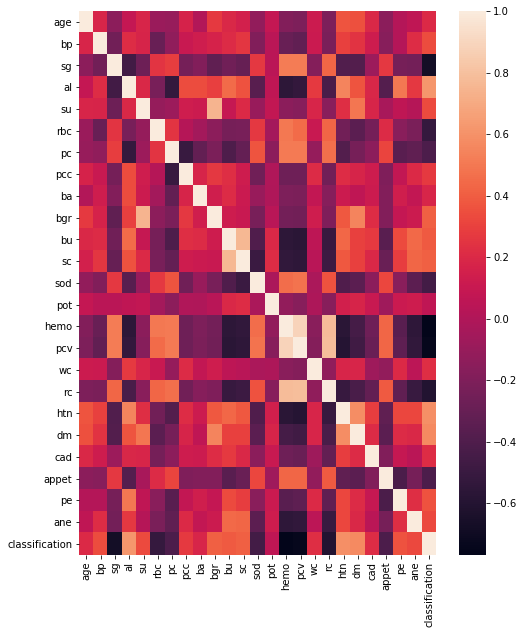

In [5]:
f, ax = plt.subplots(figsize=(8,10))
corr = train_data.corr()
sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [6]:
# see which variables are correlated with the classification variable
train_data_corr = train_data.corr()['classification'][:-1]
features = train_data_corr[abs(train_data_corr)>0.5].sort_values(ascending=False)
print('The {} features strongly correlated with the classification variable:\n{}'.format(len(features),features))

The 8 features strongly correlated with the classification variable:
al      0.615873
htn     0.586535
dm      0.569364
rbc    -0.518775
rc     -0.608310
sg     -0.673659
pcv    -0.740118
hemo   -0.767726
Name: classification, dtype: float64


From my correlation table, it appears that the variables `al`, `htn`, `dm` are **positively correlated** with `classification` while `rbc`, `rc`, `sg`, `pcv`, `hemo` are **negatively correlated** with `classification`.

**b.** Propose a deep learning-based model development plan using the **labeled data**. Please explain each step of your model and justifications wherever appropriate. You may answer this question in paragraph format, well-labeled schematics (e.g. flow-chart), and/or pseudocode. Your proposed model must include the following elements:

- A feed-forward neural network consisting of at least 5 hidden layers
- Split the **labeled data** into a **training portion** and a **validation portion**. You can decide on a ratio to perform this split.
- Hyperparameters to optimize (e.g. learning rate, momentum)
- Regularization (e.g. L1, L2, elastic-net, or deep learning-specific methods such as drop-out)

>For my deep learning-based model development on the labeled data, I will be using Tensorflow's Keras to create a feed-forward neural network consisting of 5 hidden layers. I will split 70% of the labeled data as the training portion and 30% as the validation portion using `sklearn`'s `train_test_split` function. To create my feed-forward neural network, I will use `keras.models.Sequential` and to create my layers within this neural network, I will use `keras.layers.Dense`. The input layer will consist of a specified number of nodes/neurons, the `input_dim` which is the number of features/columns from the labeled data, and the `activation` parameter which will be `relu`. Before each of the 5 hidden layers and the output layers, I will add the regularization layer `Dropout` with a value of 0.3 to prevent overfitting. Each of the hidden layers will consist of a specified number of neurons/nodes and the `relu` activation parameter. The output layer will consist of only 1 neuron/node, as this is a classification problem, with a `activation` parameter of `sigmoid`. To run my neural network, I will use the `compile` function where I can specify my `optimizer`, `loss`, and `metrics`. My `optimizer` will be Adam, my `loss` will be `binary_crossentropy`, and my `metrics` will be accuracy. In the `optimizer` parameter, I can tune my hyperparameter of either learning rate, momentum, or decay. In this case, the default learning rate for the Adam optimizer is 0.001; I will first test my neural network using the default learning rate and if it performs horribly, I will change the learning rate. Once my neural network is compiled, I will fit it on the training portion, validate it with the validation portion, assess the performance, and apply it to the unlabeled data to output my predictions.

**c.** Train a feed-forward neural network model you have proposed in part _b_ using the **training portion of the labeled data** that you have split:

- You may perform data transformation, feature selection, and/or feature engineering as you wish.
- You may use any python libraries (e.g. *sklearn, Tensorflow/Keras, or PyTorch*) to complete this task.
- However, you CANNOT use external software, models, or datasets to train the model.

In [7]:
def columnwise_standard_normalize(vec):
    """
    Helper function to perform zero-centering and s.d. scaling
    
    @param vec: 1D array (e.g. column in a 2D dataframe)
    """
    mu = np.mean(vec)
    sd = np.std(vec)
    return (vec - mu) / sd

def preprocess(df, continuous_cols, categorical_cols):
    """
    Apply standard normalization to continuous variables
    
    @param df: Dataframe
    @param continuous_cols: Columns that are continuous variables
    @param categorical_cols: Columns that are categorical
    
    Returns the standrad normalized columns
    """
    for c in categorical_cols:
        df.loc[:,c] = df.loc[:,c].astype('category')
    
    for c in continuous_cols:
        df.loc[:,c] = columnwise_standard_normalize(df.loc[:,c])
        
    return df

In [8]:
continuous_cols = ['age', 'bp', 'sg', 'bgr', 
                   'bu', 'sc', 'sod', 'pot', 
                   'hemo', 'pcv', 'wc', 'rc']

categorical_cols = ['al', 'su', 'rbc', 
                    'pc', 'pcc', 'ba', 
                    'htn', 'dm', 'cad', 
                    'appet', 'pe', 'ane']

train_scaled = preprocess(train_data.drop(columns='classification'), continuous_cols, categorical_cols)
train_scaled.head()
#train_scaled.shape

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
patient_0,0.289418,0.272263,-1.271836,1,0,1,1,0,0,0.223020,...,0.338958,0.155543,1.010653,0.422591,1,1,0,0,1,0
patient_1,1.098172,-0.491091,-1.271836,1,0,1,0,1,1,0.297915,...,-1.023086,-1.338593,0.306588,-1.148622,0,1,0,0,0,0
patient_2,1.444780,-0.491091,-0.392687,1,0,1,1,0,0,-0.688200,...,-0.808027,-0.763925,0.306588,-0.854019,1,0,0,1,0,0
patient_3,0.000578,-1.254445,1.365612,0,0,1,1,0,0,-0.600823,...,0.159741,1.189945,-0.109450,0.618992,0,0,0,1,0,0
patient_4,0.404954,-0.491091,1.365612,0,0,1,1,0,0,-0.738130,...,1.378412,1.649680,0.146573,0.618992,0,0,0,1,0,0


In [9]:
train_features = np.asarray(train_scaled).astype(np.float32)

# split the data: 70% training, 30% validation
X_train, X_val, y_train, y_val = train_test_split(train_features,
                                                  train_data['classification'],
                                                  test_size = 0.3,
                                                  random_state = 50)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape = (train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# tuning my hyperparameters
adam = tf.keras.optimizers.Adam()

# First test on default learning rate
# default learning rate is 0.001
model.compile(optimizer = adam, # or 'adam'
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=5)

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val,y_val),
                    callbacks = [es],
                    verbose=0)

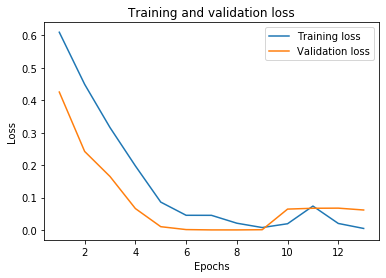

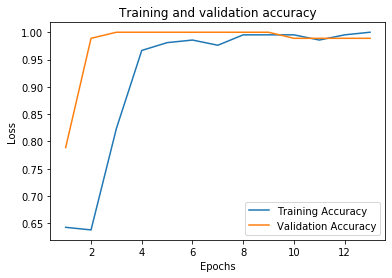

In [11]:
history_dict = history.history

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, train_acc, label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**d.** Apply your trained model to the **validation portion of the labeled data** which you have split. Show a *confusion matrix* and report *precision, recall, true positive rate, false positive rate*.

In [12]:
y_pred = model.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val,np.around(y_pred,0)).ravel()
print('Precision:',tp/(tp+fp))
print('Recall:',tp/(tp+fn))
print('True Positive Rate:',tp/(tp+fn))
print('False Positive Rate:',fp/(fp+tn))
conf_matrix = confusion_matrix(y_val,np.around(y_pred,0))
print(conf_matrix)
print('Accuracy:',accuracy_score(y_val,np.around(y_pred,0)))

Precision: 1.0
Recall: 0.9833333333333333
True Positive Rate: 0.9833333333333333
False Positive Rate: 0.0
[[30  0]
 [ 1 59]]
Accuracy: 0.9888888888888889


**e.** Apply your trained model to the **unlabeled data** (*hw3_unlabeled_data.csv, n=100*). Store your prediction as a new column named *"classification"* and export a **new CSV file. Please submit a copy of your saved CSV as a separate file on Canvas.**

In [13]:
test_data = pd.read_csv('hw3_unlabeled_data.csv',index_col=0)
test_data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
patient_300,69,70,1.010,4,3,1,0,1,1,214,...,9.4,28,11500,3.3,1,1,1,1,1,1
patient_301,81,60,1.010,0,0,0,0,0,0,148,...,10.9,35,9400,2.4,1,1,1,0,1,0
patient_302,45,80,1.015,0,0,0,0,0,0,107,...,11.8,37,10200,4.2,0,0,0,1,0,0
patient_303,30,80,1.025,0,0,1,1,0,0,96,...,13.8,42,9000,4.5,0,0,0,1,0,0
patient_304,65,90,1.020,2,1,0,1,0,0,270,...,12.0,36,9800,4.9,1,1,0,0,0,1


In [20]:
test_scaled = preprocess(test_data, continuous_cols, categorical_cols)
test_features = np.asarray(test_scaled).astype(np.float32)
predictions = model.predict(test_features,batch_size=32)
predictions = np.around(predictions,0)
predictions = predictions.astype('int')
test_data['classification'] = predictions
test_data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
patient_300,0.977934,-0.426058,-1.092504,4,3,1,0,1,1,0.923522,...,-0.974498,1.256565,-1.055239,1,1,1,1,1,1,1
patient_301,1.697003,-1.081531,-1.092504,0,0,0,0,0,0,-0.014064,...,-0.208039,0.485891,-1.886136,1,1,1,0,1,0,1
patient_302,-0.460204,0.229416,-0.277203,0,0,0,0,0,0,-0.596504,...,0.010949,0.779481,-0.224342,0,0,0,1,0,0,1
patient_303,-1.359040,0.229416,1.353401,0,0,1,1,0,0,-0.752768,...,0.558420,0.339096,0.052623,0,0,0,1,0,0,0
patient_304,0.738244,0.884889,0.538099,2,1,0,1,0,0,1.719050,...,-0.098545,0.632686,0.421911,1,1,0,0,0,1,1


In [21]:
sum(test_data['classification'] == 1)

67

In [42]:
test_data.to_csv('Lin_Justin_hw3_unlabeled_data_complete.csv')

## Part II. Unsupervised Deep Learning for Data Representation 

From the Pan-cancer dataset (the data in the Canvas folder titled *PanCancer Data*, under *PCA Demo* in the *Programming Demos* folder), apply *t-SNE* to visualize the data. You may use the *sklearn* library. Please provide a description of your results.

In [43]:
rnaseq = pd.read_csv('PanCancer Data/data.csv',index_col=0)
rnaseq.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [44]:
labels = pd.read_csv('PanCancer Data/labels.csv', index_col = 0)
labels.head()

,Class
sample_0,PRAD
sample_1,LUAD
sample_2,PRAD
sample_3,PRAD
sample_4,BRCA


Text(0, 0.5, 't-SNE 2')

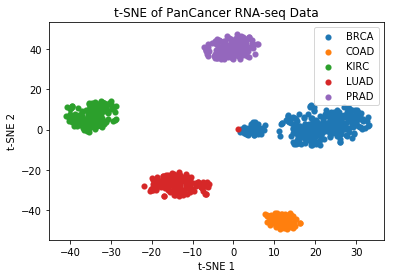

In [45]:
from sklearn.manifold import TSNE

X = rnaseq.values
y = labels['Class'].values

X_embedded = TSNE(n_components=2).fit_transform(X)

for i in np.unique(y):
    plt.scatter(X_embedded[y==i,0],X_embedded[y==i,1],
               lw=0.1,label=i)
plt.title('t-SNE of PanCancer RNA-seq Data')
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

From the t-SNE plot, we can see 5 distinct clusters however, there appears to be a red dot on the BRCA (blue) cluster.